In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline
%load_ext autoreload
%autoreload 2

from utils.transformer import TransformerEncoder, PatchClassEmbedding, Patches
from tensorflow.keras.applications.efficientnet import preprocess_input
from utils.visualize import plotHistory, plot_misclassified_images
from utils.tools import CustomSchedule
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import os
import shutil
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set some paths
model_dir = Path('bin')

# Configure GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", tf.test.gpu_device_name())
    except RuntimeError as e:
        print(e)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Paths to the new dataset directories
main_dataset_path = '/content/drive/MyDrive/Datasets/Medicinal Plant-Bijly-withBG'  # Update this with the actual path
train_dir = os.path.join(main_dataset_path, 'train')
test_dir = os.path.join(main_dataset_path, 'test')
val_dir = os.path.join(main_dataset_path, 'validation')

In [ ]:
# Load the datasets using image_dataset_from_directory
batch_size = 32
img_size = (224, 224)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size,
    label_mode='int'  # Labels will be integers representing the class index
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size,
    label_mode='int'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle=False,
    batch_size=batch_size,
    image_size=img_size,
    label_mode='int'
)

Found 3500 files belonging to 10 classes.
Found 500 files belonging to 10 classes.
Found 999 files belonging to 10 classes.


In [ ]:
# Class names
class_names = train_dataset.class_names
print("Class Names:", class_names)

# Dataset Info
n_train = len(train_dataset) * batch_size
n_val = len(validation_dataset) * batch_size
n_test = len(test_dataset) * batch_size

print(f"Training Samples: {n_train}, Validation Samples: {n_val}, Test Samples: {n_test}")

Class Names: ['Bohera', 'Devilbackbone', 'Haritoki', 'Lemongrass', 'Nayontara', 'Neem', 'Pathorkuchi', 'Thankuni', 'Tulsi', 'Zenora']
Training Samples: 3520, Validation Samples: 512, Test Samples: 1024


In [ ]:
# 2.2 Build a pre-process pipeline with keras preprocess
pre_process_pipeline = tf.keras.Sequential([
        tf.keras.layers.Lambda(lambda x: preprocess_input(x)),
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomContrast(0.4),
        tf.keras.layers.RandomRotation(factor=0.1)
])

In [ ]:
# 3.0 Build the Hybrid Vision Transformer (ViT)
# 3.1 Backbone
backbone = tf.keras.applications.EfficientNetB3(input_shape=(224, 224, 3), include_top=False)
backbone.summary()
for layer in backbone.layers:
    layer.trainable = False

43941136/43941136 [==============================] - 0s 0us/step
Model: "efficientnetb3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescal

In [ ]:
# 3.2 Build the model
# Model configurations
d_model = 128
d_ff = d_model * 2
n_heads = 8
mlp_head_size = 256
dropout = 0.1
activation = 'relu'
n_layers = 2
patch_size = 1

def build_vit(backbone, transformer):
    # Input
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))

    # Data pre-processing pipeline
    x = pre_process_pipeline(inputs)

    # Feed Backbone
    x = backbone(x)

    backbone_shape = x.shape

    # Patch Creation
    x = Patches(patch_size)(x)

    # Linear Projection of Flattened Patches
    x = tf.keras.layers.Dense(d_model)(x)

    # Position Embedding + Extra learnable class embedding
    n_patches = (backbone_shape[1] // patch_size) ** 2
    x = PatchClassEmbedding(d_model, n_patches)(x)

    # Transformer Model
    x = transformer(x, training=True)  # Pass the training argument

    # Take only the Extra Learnable Class
    x = tf.keras.layers.Lambda(lambda x: x[:, 0, :])(x)

    # MLP Head
    x = tf.keras.layers.Dense(mlp_head_size, activation='relu')(x)
    outputs = tf.keras.layers.Dense(len(class_names))(x)  # output neurons equal to number of classes

    return tf.keras.models.Model(inputs, outputs)

transformer = TransformerEncoder(d_model, n_heads, d_ff, dropout, activation, n_layers)

vit_model = build_vit(backbone, transformer)
vit_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb3 (Functional  (None, 7, 7, 1536)        10783535  
 )                                                               
                                                                 
 patches (Patches)           (None, None, 1536)        0         
                                                                 
 dense_12 (Dense)            (None, None, 128)         196736    
                                                                 
 patch_class_embedding (Pat  (None, 50, 128)           6528      
 chClassEmbedding)                                           

In [ ]:
# 4.0 Train the Network
# Some training configurations
lr = 3e-4
epochs = 15

lr = CustomSchedule(d_model, warmup_steps=20000.0)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
vit_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

name_model = 'vision_transformer.h5'
checkpointer = tf.keras.callbacks.ModelCheckpoint(
    model_dir.joinpath(name_model),
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True
)

history = vit_model.fit(train_dataset,
                        validation_data=validation_dataset,
                        epochs=epochs,
                        callbacks=[checkpointer])

Epoch 1/15
110/110 [==============================] - 225s 2s/step - loss: 2.5036 - accuracy: 0.1191 - val_loss: 2.5017 - val_accuracy: 0.1540
Epoch 2/15
110/110 [==============================] - 115s 1s/step - loss: 2.2465 - accuracy: 0.1660 - val_loss: 2.1324 - val_accuracy: 0.2520
Epoch 3/15
110/110 [==============================] - 114s 1s/step - loss: 1.8760 - accuracy: 0.4109 - val_loss: 1.7059 - val_accuracy: 0.5680
Epoch 4/15
110/110 [==============================] - 115s 1s/step - loss: 1.4252 - accuracy: 0.6674 - val_loss: 1.2392 - val_accuracy: 0.6860
Epoch 5/15
110/110 [==============================] - 115s 1s/step - loss: 0.9928 - accuracy: 0.7934 - val_loss: 0.8652 - val_accuracy: 0.7820
Epoch 6/15
110/110 [==============================] - 116s 1s/step - loss: 0.6751 - accuracy: 0.8631 - val_loss: 0.6150 - val_accuracy: 0.8520
Epoch 7/15
110/110 [==============================] - 115s 1s/step - loss: 0.4599 - accuracy: 0.9117 - val_loss: 0.4474 - val_accuracy: 0.8940

32/32 [==============================] - 32s 923ms/step - loss: 0.1745 - accuracy: 0.9359


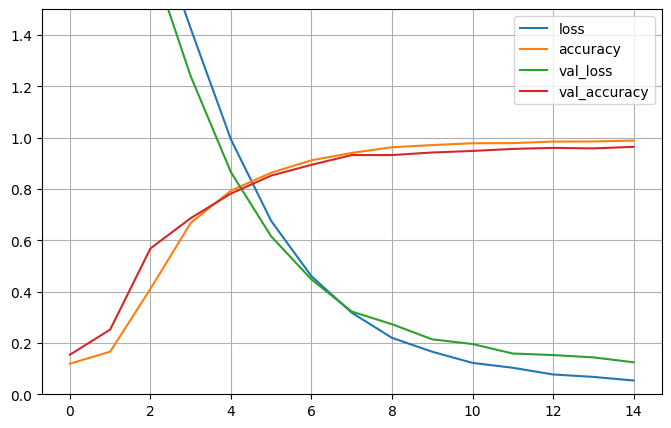

In [ ]:
# 5.0 Test the Model
# Load best weights
vit_model.load_weights(model_dir.joinpath(name_model))

# Evaluate the model
vit_model.evaluate(test_dataset)

plotHistory(history)

In [ ]:
# Get model predictions
y_pred = np.concatenate([np.argmax(vit_model.predict(X), axis=1) for X, _ in test_dataset])
y_true = np.concatenate([y for _, y in test_dataset])

1/1 [==============================] - 3s 3s/step


<Figure size 3000x1000 with 0 Axes>

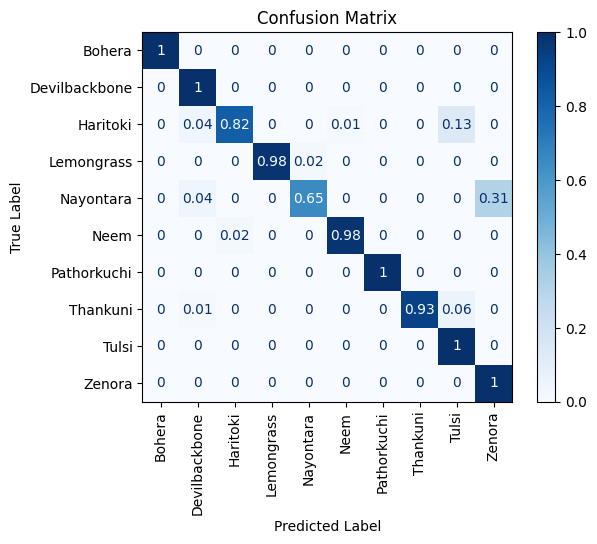

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')

# Display confusion matrix
plt.figure(figsize=(30, 10))
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Generate classification report
from sklearn.metrics import classification_report

class_report = classification_report(y_true, y_pred, target_names=class_names)

print("Classification Report:")
print(class_report)

Classification Report:
               precision    recall  f1-score   support

       Bohera       1.00      1.00      1.00       100
Devilbackbone       0.92      1.00      0.96       100
     Haritoki       0.98      0.82      0.89        99
   Lemongrass       1.00      0.98      0.99       100
    Nayontara       0.97      0.65      0.78       100
         Neem       0.99      0.98      0.98       100
  Pathorkuchi       1.00      1.00      1.00       100
     Thankuni       1.00      0.93      0.96       100
        Tulsi       0.84      1.00      0.91       100
       Zenora       0.76      1.00      0.87       100

     accuracy                           0.94       999
    macro avg       0.95      0.94      0.93       999
 weighted avg       0.95      0.94      0.93       999



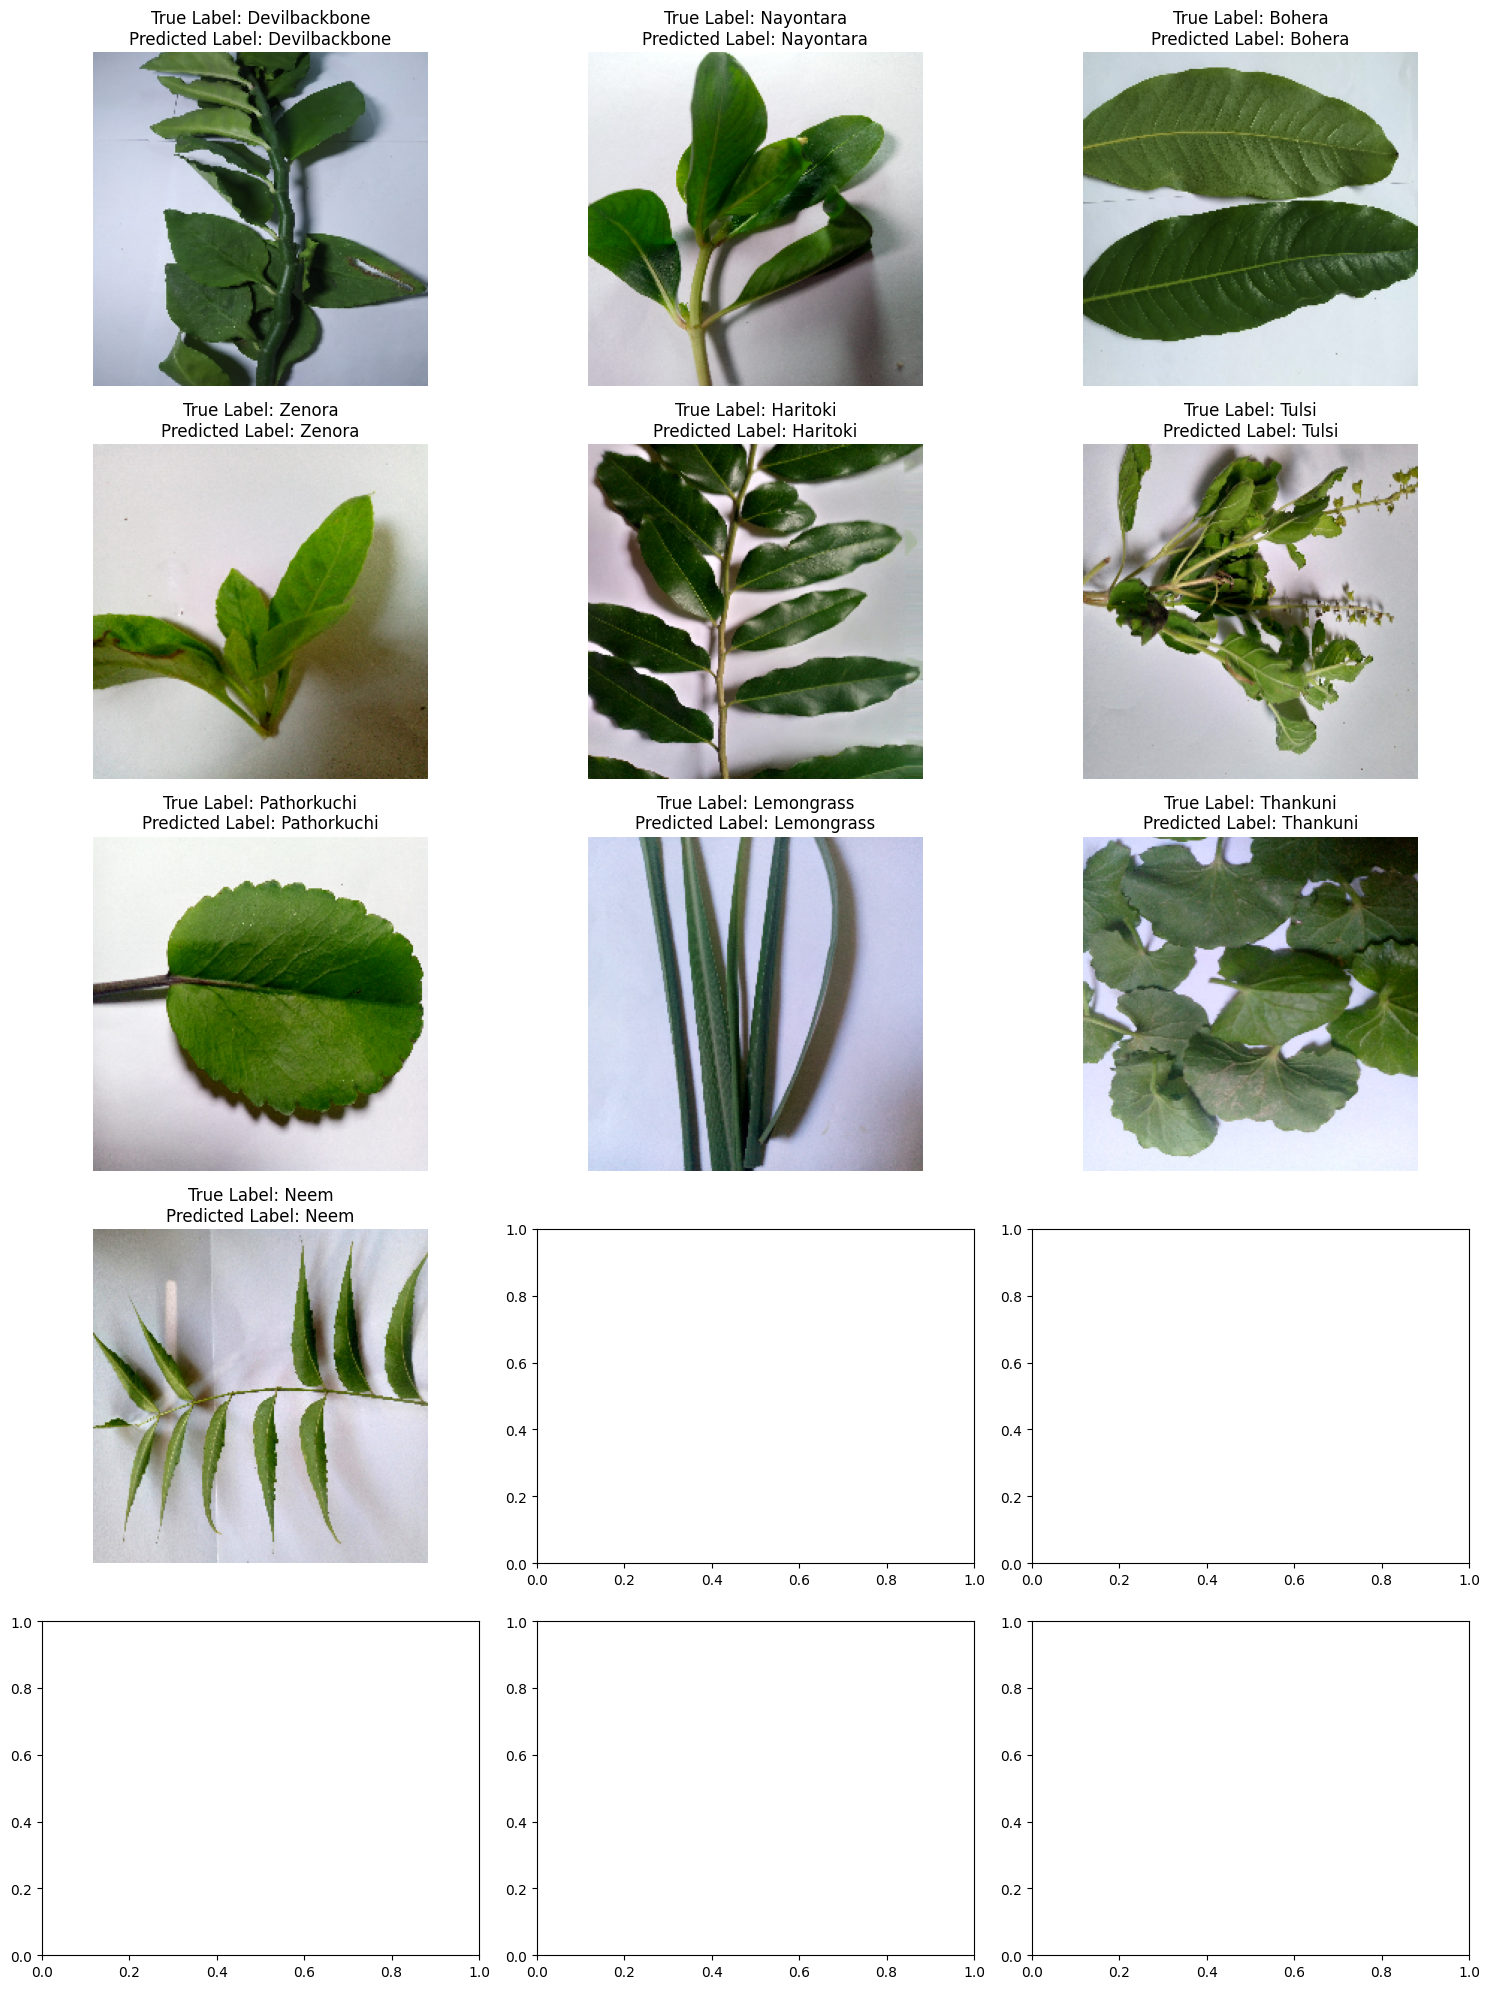

In [ ]:
# Visualize accuracy using example images from different classes
def visualize_accuracy(model, test_dataset, class_names, num_examples_per_row=3, num_rows=5):
    example_count = 0
    fig, axes = plt.subplots(num_rows, num_examples_per_row, figsize=(15, 20))

    # Ensure that we shuffle the test dataset
    shuffled_test_dataset = test_dataset.unbatch().shuffle(buffer_size=1000)

    # Create a set to track which classes have been displayed
    displayed_classes = set()

    # Loop through the shuffled test dataset
    for image, label in shuffled_test_dataset:
        if example_count >= num_examples_per_row * num_rows:
            break

        true_label = class_names[int(label)]

        # Skip images of a class that we've already displayed enough of
        if len(displayed_classes) >= len(class_names):
            break

        if true_label in displayed_classes:
            continue

        # Convert image to numpy array and normalize pixel values
        image_np = image.numpy().astype("float32")

        # Make predictions
        predictions = model.predict(np.expand_dims(image_np, axis=0), verbose=0)
        predicted_label = class_names[np.argmax(predictions)]

        # Normalize pixel values to [0, 1] for proper visualization
        image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

        # Plot the image and add labels
        ax = axes[example_count // num_examples_per_row, example_count % num_examples_per_row]
        ax.imshow(image_np)
        ax.set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")
        ax.axis('off')

        example_count += 1
        displayed_classes.add(true_label)

    plt.tight_layout()
    plt.show()

# Call the visualize_accuracy function
visualize_accuracy(vit_model, test_dataset, class_names, num_examples_per_row=3, num_rows=5)
